# Feature Selection

Feature selection is the process of selecting a subset of relevant features for use in model construction


## Top reasons to use feature selection are:
* It enables the machine learning algorithm to train faster.
* It reduces the complexity of a model and makes it easier to interpret.
* It improves the accuracy of a model if the right subset is chosen.
* It reduces overfitting.

***Import the packages we will use for this notebook***

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 300)
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(style="whitegrid")



***Set up or initial dataframe by removing variable and transforming others.***

In [2]:
df_base = pd.read_csv('kc_house_data.csv',index_col='id')
print(df_base.columns.tolist())

df_base['yr_old']=2017 - df_base['yr_built']

df_base = df_base[['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade',
       'sqft_basement', 'yr_old']]

['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


#### Data Cleaning

This data set is very clean since it came from Kaggle. If it wasn't so clean what are some things I would want to check on for data cleaning?




-
-
-
-

## Outlier Detection: Z-Score Method

The intuition behind the Z-score method of outlier detection is that, once we’ve centred and rescaled the data, anything that is too far from zero (the threshold is usually a Z-score of 3 or -3) should be considered an outlier.


    

***Function to find outliers***

In [3]:
def outliers_z_score(data, th):
    threshold = th

    mean_y = np.mean(data)
    stdev_y = np.std(data)
    z_scores = [(y - mean_y) / stdev_y for y in data]
    return np.where(np.abs(z_scores) > threshold)

### Modified Z-score method

A benefit of the modified Z-score method is that it uses the median and MAD rather than the mean and standard deviation. The median and MAD are robust measures of central tendency and dispersion

In [4]:
def outliers_modified_z_score(data, th):
    threshold = th

    median_y = np.median(data)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in data])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in data]
    return np.where(np.abs(modified_z_scores) > threshold)


### IQR method

Another robust method for labeling outliers is the IQR (interquartile range) method of outlier detection developed by John Tukey, the pioneer of exploratory data analysis. 

 Tukey considered any data point that fell outside of either 1.5 times the IQR below the first – or 1.5 times the IQR above the third – quartile to be “outside” or “far out”. 

<img src='./boxplot.png' width=400/>

In [5]:
def outliers_iqr(data):
    quartile_1, quartile_3 = np.percentile(data, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((data > upper_bound) | (data < lower_bound))

***Let's look at the box and whiskers plot for our variables***

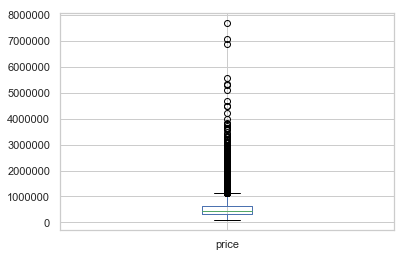

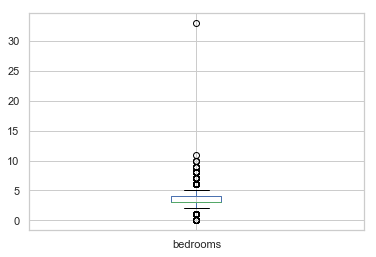

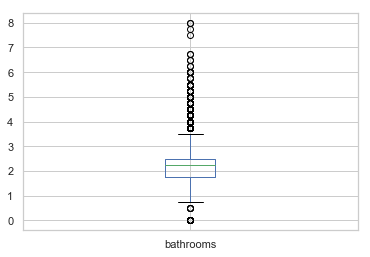

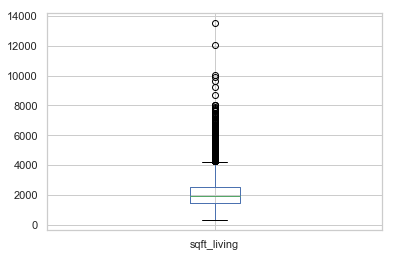

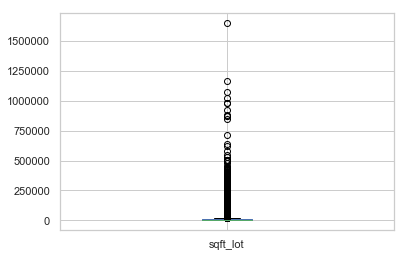

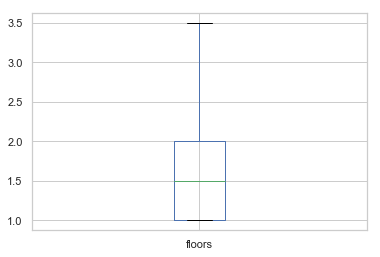

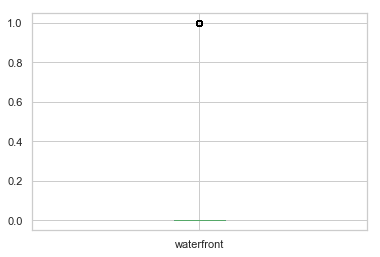

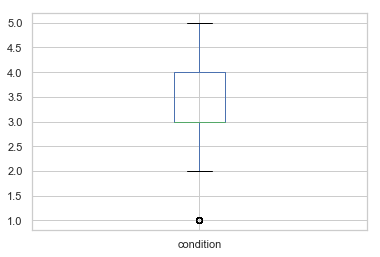

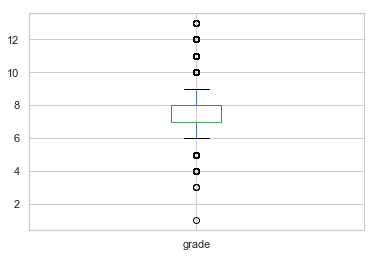

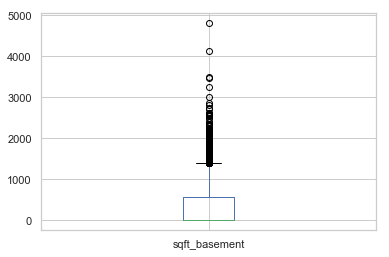

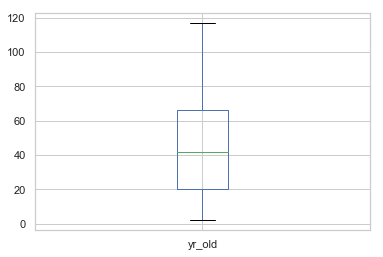

In [6]:
for i in df_base.columns:
    df_base.boxplot(column=i)
    plt.show()

***Based on our boxplot, we will remove houses that cost more than $4,000,000***

In [7]:
df_base = df_base[df_base.price < 4000000]
target = df_base.price
features_base = df_base[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade',
       'sqft_basement', 'yr_old']]
df_base.shape

(21601, 11)

***Now we will create polynomial and interaction terms***

In [8]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit(features_base)
column_names = poly.get_feature_names(features_base.columns)
df_poly= pd.DataFrame(poly.transform(features_base), columns=column_names)

X_train_base, X_test_base, y_train_base, y_test = train_test_split(df_poly, target, random_state=34,test_size=0.2)


***Now we will scale those terms***

In [9]:
scaler = StandardScaler()
scaler.fit(X_train_base)
X_train_base =pd.DataFrame(data=scaler.transform(X_train_base), columns=column_names)
X_test_base =pd.DataFrame(data=scaler.transform(X_test_base), columns=column_names)

In [10]:
print(X_train_base.shape)
print(X_test_base.shape)
X_train_base.head()

(17280, 285)
(4321, 285)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_basement,yr_old,bedrooms^2,bedrooms bathrooms,bedrooms sqft_living,bedrooms sqft_lot,bedrooms floors,bedrooms waterfront,bedrooms condition,bedrooms grade,bedrooms sqft_basement,bedrooms yr_old,bathrooms^2,bathrooms sqft_living,bathrooms sqft_lot,bathrooms floors,bathrooms waterfront,bathrooms condition,bathrooms grade,bathrooms sqft_basement,bathrooms yr_old,sqft_living^2,sqft_living sqft_lot,sqft_living floors,sqft_living waterfront,sqft_living condition,sqft_living grade,sqft_living sqft_basement,sqft_living yr_old,sqft_lot^2,sqft_lot floors,sqft_lot waterfront,sqft_lot condition,sqft_lot grade,sqft_lot sqft_basement,sqft_lot yr_old,floors^2,floors waterfront,floors condition,floors grade,floors sqft_basement,floors yr_old,waterfront^2,waterfront condition,waterfront grade,waterfront sqft_basement,waterfront yr_old,condition^2,condition grade,condition sqft_basement,condition yr_old,grade^2,grade sqft_basement,grade yr_old,sqft_basement^2,sqft_basement yr_old,yr_old^2,bedrooms^3,bedrooms^2 bathrooms,bedrooms^2 sqft_living,bedrooms^2 sqft_lot,bedrooms^2 floors,bedrooms^2 waterfront,bedrooms^2 condition,bedrooms^2 grade,bedrooms^2 sqft_basement,bedrooms^2 yr_old,bedrooms bathrooms^2,bedrooms bathrooms sqft_living,bedrooms bathrooms sqft_lot,bedrooms bathrooms floors,bedrooms bathrooms waterfront,bedrooms bathrooms condition,bedrooms bathrooms grade,bedrooms bathrooms sqft_basement,bedrooms bathrooms yr_old,bedrooms sqft_living^2,bedrooms sqft_living sqft_lot,bedrooms sqft_living floors,bedrooms sqft_living waterfront,bedrooms sqft_living condition,bedrooms sqft_living grade,bedrooms sqft_living sqft_basement,bedrooms sqft_living yr_old,bedrooms sqft_lot^2,bedrooms sqft_lot floors,bedrooms sqft_lot waterfront,bedrooms sqft_lot condition,bedrooms sqft_lot grade,bedrooms sqft_lot sqft_basement,bedrooms sqft_lot yr_old,bedrooms floors^2,bedrooms floors waterfront,bedrooms floors condition,bedrooms floors grade,bedrooms floors sqft_basement,bedrooms floors yr_old,bedrooms waterfront^2,bedrooms waterfront condition,bedrooms waterfront grade,bedrooms waterfront sqft_basement,bedrooms waterfront yr_old,bedrooms condition^2,bedrooms condition grade,bedrooms condition sqft_basement,bedrooms condition yr_old,bedrooms grade^2,bedrooms grade sqft_basement,bedrooms grade yr_old,bedrooms sqft_basement^2,bedrooms sqft_basement yr_old,bedrooms yr_old^2,bathrooms^3,bathrooms^2 sqft_living,bathrooms^2 sqft_lot,bathrooms^2 floors,bathrooms^2 waterfront,bathrooms^2 condition,bathrooms^2 grade,bathrooms^2 sqft_basement,bathrooms^2 yr_old,bathrooms sqft_living^2,bathrooms sqft_living sqft_lot,bathrooms sqft_living floors,bathrooms sqft_living waterfront,bathrooms sqft_living condition,bathrooms sqft_living grade,bathrooms sqft_living sqft_basement,bathrooms sqft_living yr_old,bathrooms sqft_lot^2,bathrooms sqft_lot floors,bathrooms sqft_lot waterfront,bathrooms sqft_lot condition,bathrooms sqft_lot grade,bathrooms sqft_lot sqft_basement,bathrooms sqft_lot yr_old,bathrooms floors^2,bathrooms floors waterfront,bathrooms floors condition,bathrooms floors grade,bathrooms floors sqft_basement,bathrooms floors yr_old,bathrooms waterfront^2,bathrooms waterfront condition,bathrooms waterfront grade,bathrooms waterfront sqft_basement,bathrooms waterfront yr_old,bathrooms condition^2,bathrooms condition grade,bathrooms condition sqft_basement,bathrooms condition yr_old,bathrooms grade^2,bathrooms grade sqft_basement,bathrooms grade yr_old,bathrooms sqft_basement^2,bathrooms sqft_basement yr_old,bathrooms yr_old^2,sqft_living^3,sqft_living^2 sqft_lot,sqft_living^2 floors,sqft_living^2 waterfront,sqft_living^2 condition,sqft_living^2 grade,sqft_living^2 sqft_basement,sqft_living^2 yr_old,sqft_living sqft_lot^2,sqft_living sqft_lot floors,sqft_living sqft_lot waterfront,sqft_living sqft_lot condition,sqft_living sqft_lot grade,sqft_living sqft_lot sqft_basement,sqft_living sqft_lot 

***I created this function just in case I lose track of what features I have and I need to reset it***

In [11]:
def reset_data():
    df = pd.read_csv('kc_house_data.csv',index_col='id')
    df['yr_old']=2017 - df['yr_built']

    df = df[['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
           'floors', 'waterfront', 'condition', 'grade',
           'sqft_basement', 'yr_old']]
    df = df[df.price < 4000000]
    target = df.price
    features = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
           'floors', 'waterfront', 'condition', 'grade',
           'sqft_basement', 'yr_old']]
    poly = PolynomialFeatures(degree=3, include_bias=False)
    poly.fit(features)
    column_names = poly.get_feature_names(features.columns)
    df_poly= pd.DataFrame(poly.transform(features), columns=column_names)

    X_train, X_test, y_train, y_test = train_test_split(df_poly, target, random_state=34,test_size=0.2)
    poly = PolynomialFeatures(degree=3, include_bias=False)
    poly.fit(features)
    column_names = poly.get_feature_names(features.columns)
    df_poly= pd.DataFrame(poly.transform(features), columns=column_names)

    X_train, X_test, y_train, y_test = train_test_split(df_poly, target, random_state=34,test_size=0.2)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train =pd.DataFrame(data=scaler.transform(X_train), columns=column_names)
    X_test =pd.DataFrame(data=scaler.transform(X_test), columns=column_names)
    return X_train, X_test, y_train, y_test

***Here I am calling reset_data and assigning the returned values to specific variables***

In [12]:
X_train, X_test, y_train, y_test=  reset_data()

***Let's fit a baseline model with all of the variables***

In [13]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_pred = lm.predict(X_test)
baseline_train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
baseline_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(baseline_train_rmse) )
print('Testing Error: '+ str(baseline_test_rmse) )

Training Error: 123141.87401184587
Testing Error: 197456.5048648691


***Here I divided the Eorrs by the standard deviation to bring it down to a scale similiar to a Z-score***

In [14]:
print('Training Error in Z-score: '+ str(baseline_train_rmse/y_train.std()) )
print('Testing Error in Z-score: '+ str(baseline_test_rmse/y_train.std()) )



Training Error in Z-score: 0.35226795996778176
Testing Error in Z-score: 0.5648574110901105


***Plot the residuals after fitting a linear model***

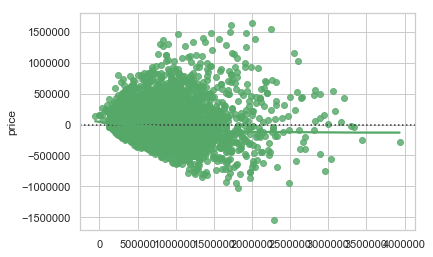

In [15]:

sns.residplot(y_train_pred, y_train, lowess=True, color="g")

### Based on this residual plot how might we want to transform our data?

***Plot to compare the size of all of our coefficients***

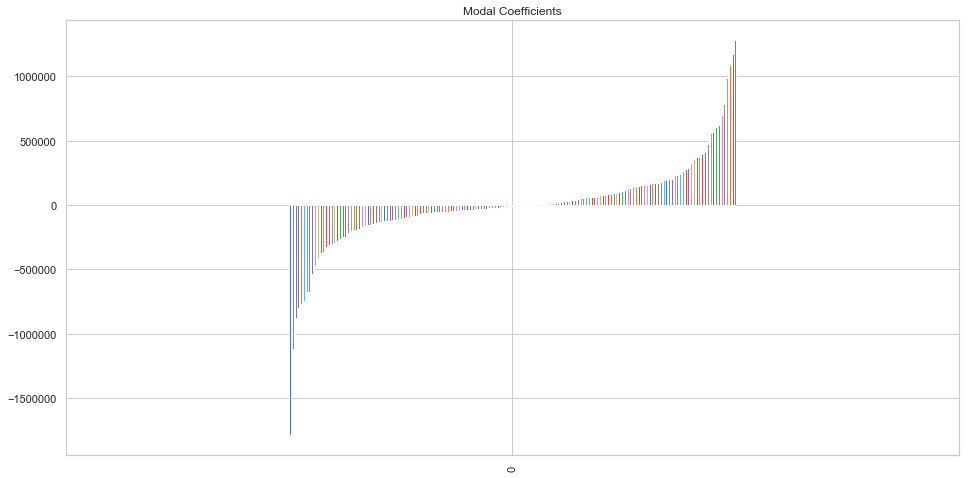

In [16]:
coef = pd.DataFrame(data=lm.coef_ ).T
coef.columns = column_names

model_coef = coef.T.sort_values(by=0).T
model_coef.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8),)

## Types of Feature Selection

* Filter Methods
* Wrapper Methods
* Embedded Methods

# Filter Methods
Filter feature selection methods apply a statistical measure to assign a scoring to each feature. The features are ranked by the score and either selected to be kept or removed from the dataset. The methods are often univariate and consider the feature independently, or with regard to the dependent variable.

![alt text](Filter_1.png)

**Examples:** 
* F-Test
* Chi squared test 
* Information gain 
* Correlation coefficient scores

![alt text](FS1.webp)

### Removing Variables based on correlation coefficient

In [17]:
# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_basement,yr_old,bedrooms^2,bedrooms bathrooms,bedrooms sqft_living,bedrooms sqft_lot,bedrooms floors,bedrooms waterfront,bedrooms condition,bedrooms grade,bedrooms sqft_basement,bedrooms yr_old,bathrooms^2,bathrooms sqft_living,bathrooms sqft_lot,bathrooms floors,bathrooms waterfront,bathrooms condition,bathrooms grade,bathrooms sqft_basement,bathrooms yr_old,sqft_living^2,sqft_living sqft_lot,sqft_living floors,sqft_living waterfront,sqft_living condition,sqft_living grade,sqft_living sqft_basement,sqft_living yr_old,sqft_lot^2,sqft_lot floors,sqft_lot waterfront,sqft_lot condition,sqft_lot grade,sqft_lot sqft_basement,sqft_lot yr_old,floors^2,floors waterfront,floors condition,floors grade,floors sqft_basement,floors yr_old,waterfront^2,waterfront condition,waterfront grade,waterfront sqft_basement,waterfront yr_old,condition^2,condition grade,condition sqft_basement,condition yr_old,grade^2,grade sqft_basement,grade yr_old,sqft_basement^2,sqft_basement yr_old,yr_old^2,bedrooms^3,bedrooms^2 bathrooms,bedrooms^2 sqft_living,bedrooms^2 sqft_lot,bedrooms^2 floors,bedrooms^2 waterfront,bedrooms^2 condition,bedrooms^2 grade,bedrooms^2 sqft_basement,bedrooms^2 yr_old,bedrooms bathrooms^2,bedrooms bathrooms sqft_living,bedrooms bathrooms sqft_lot,bedrooms bathrooms floors,bedrooms bathrooms waterfront,bedrooms bathrooms condition,bedrooms bathrooms grade,bedrooms bathrooms sqft_basement,bedrooms bathrooms yr_old,bedrooms sqft_living^2,bedrooms sqft_living sqft_lot,bedrooms sqft_living floors,bedrooms sqft_living waterfront,bedrooms sqft_living condition,bedrooms sqft_living grade,bedrooms sqft_living sqft_basement,bedrooms sqft_living yr_old,bedrooms sqft_lot^2,bedrooms sqft_lot floors,bedrooms sqft_lot waterfront,bedrooms sqft_lot condition,bedrooms sqft_lot grade,bedrooms sqft_lot sqft_basement,bedrooms sqft_lot yr_old,bedrooms floors^2,bedrooms floors waterfront,bedrooms floors condition,bedrooms floors grade,bedrooms floors sqft_basement,bedrooms floors yr_old,bedrooms waterfront^2,bedrooms waterfront condition,bedrooms waterfront grade,bedrooms waterfront sqft_basement,bedrooms waterfront yr_old,bedrooms condition^2,bedrooms condition grade,bedrooms condition sqft_basement,bedrooms condition yr_old,bedrooms grade^2,bedrooms grade sqft_basement,bedrooms grade yr_old,bedrooms sqft_basement^2,bedrooms sqft_basement yr_old,bedrooms yr_old^2,bathrooms^3,bathrooms^2 sqft_living,bathrooms^2 sqft_lot,bathrooms^2 floors,bathrooms^2 waterfront,bathrooms^2 condition,bathrooms^2 grade,bathrooms^2 sqft_basement,bathrooms^2 yr_old,bathrooms sqft_living^2,bathrooms sqft_living sqft_lot,bathrooms sqft_living floors,bathrooms sqft_living waterfront,bathrooms sqft_living condition,bathrooms sqft_living grade,bathrooms sqft_living sqft_basement,bathrooms sqft_living yr_old,bathrooms sqft_lot^2,bathrooms sqft_lot floors,bathrooms sqft_lot waterfront,bathrooms sqft_lot condition,bathrooms sqft_lot grade,bathrooms sqft_lot sqft_basement,bathrooms sqft_lot yr_old,bathrooms floors^2,bathrooms floors waterfront,bathrooms floors condition,bathrooms floors grade,bathrooms floors sqft_basement,bathrooms floors yr_old,bathrooms waterfront^2,bathrooms waterfront condition,bathrooms waterfront grade,bathrooms waterfront sqft_basement,bathrooms waterfront yr_old,bathrooms condition^2,bathrooms condition grade,bathrooms condition sqft_basement,bathrooms condition yr_old,bathrooms grade^2,bathrooms grade sqft_basement,bathrooms grade yr_old,bathrooms sqft_basement^2,bathrooms sqft_basement yr_old,bathrooms yr_old^2,sqft_living^3,sqft_living^2 sqft_lot,sqft_living^2 floors,sqft_living^2 waterfront,sqft_living^2 condition,sqft_living^2 grade,sqft_living^2 sqft_basement,sqft_living^2 yr_old,sqft_living sqft_lot^2,sqft_living sqft_lot floors,sqft_living sqft_lot waterfront,sqft_living sqft_lot condition,sqft_living sqft_lot grade,sqft_living sqft_lot sqft_basement,sqft_living sqft_lot 

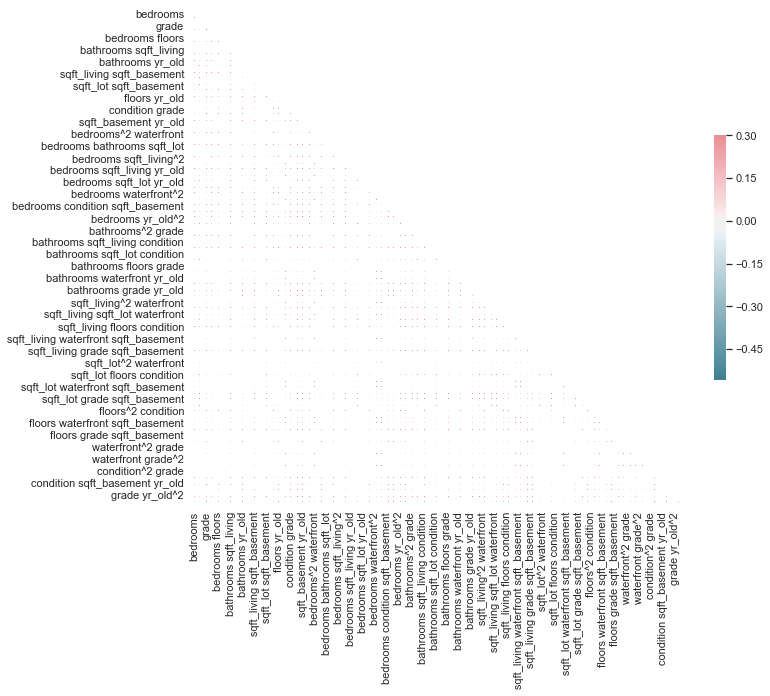

In [18]:

sns.set(style="white")


# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [19]:
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

In [20]:
len(X_train.columns)

105

***Fit a model on this subset of features***

In [21]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_pred = lm.predict(X_test)
train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 127541.1854996602
Testing Error: 190646.38633132546


***Compare to the baseline model***

In [22]:
print('Training Error: '+ str(baseline_train_rmse) )
print('Testing Error: '+ str(baseline_test_rmse) )

Training Error: 123141.87401184587
Testing Error: 197456.5048648691


###  F Test

F Test is a statistical test used to compare between models and check if the difference is significant between the model.

F-Test does a hypothesis testing model X and Y where X is a model created by just a constant and Y is the model created by a constant and a feature.

The least square errors in both the models are compared and checks if the difference in errors between model X and Y are significant or introduced by chance.

F-Test is useful in feature selection as we get to know the significance of each feature in improving the model.

Scikit learn provides the Selecting K best features using F-Test.

***Resetting the Data to start off with all variables***

In [23]:
X_train, X_test, y_train, y_test=  reset_data()

***I am using the F-test to sleect the 45 top varaibles for this model***

In [24]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=45)

selector.fit(X_train, y_train)

SelectKBest(k=45, score_func=<function f_regression at 0x1221f4620>)

In [25]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

In [26]:
X_train.shape

(17280, 45)

In [27]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_pred = lm.predict(X_test)
train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 136795.84084987774
Testing Error: 200082.43137240116


In [28]:
print('Training Error: '+ str(baseline_train_rmse) )
print('Testing Error: '+ str(baseline_test_rmse) )

Training Error: 123141.87401184587
Testing Error: 197456.5048648691


# Wrapper Methods

Wrapper methods consider the selection of a set of features as a search problem, where different combinations are prepared, evaluated and compared to other combinations. A predictive model is used to evaluate a combination of features and assign a score based on model accuracy.

The search process may be methodical such as a best-first search, it may stochastic such as a random hill-climbing algorithm, or it may use heuristics, like forward and backward passes to add and remove features.

Wrapper Methods promises you a best set of features with a extensive greedy search.

But the main drawbacks of wrapper methods is the sheer amount of models that needs to be trained. It is computationally very expensive and is infeasible with large number of features.



![alt text](Wrapper_1.webp)

### Recursive Feature Elimination

An example if a wrapper method is the recursive feature elimination algorithm.

As the name suggests, this method eliminates worst performing features on a particular model one after the other until the best subset of features are known.


Recursive elimination eliminates the least explaining features one after the other.
For data with n features,

- On first round ‘n-1’ models are created with combination of all features except one. The least performing feature is removed

- On second round ‘n-2’ models are created by removing another feature.



<img src='rfe_graph.png' width=500/>

In [29]:
X_train, X_test, y_train, y_test=  reset_data()

In [30]:
from sklearn.feature_selection import RFECV

In [31]:
ols = linear_model.LinearRegression()

In [32]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)



RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
   min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
   step=1, verbose=0)

In [33]:
selected_columns = X_train.columns[selector.support_]
removed_columns = X_train.columns[~selector.support_]
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

In [34]:
len(selected_columns)

33

In [35]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_pred = lm.predict(X_test)
train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 130507.58325137294
Testing Error: 195108.70248936745


In [36]:
print('Training Error: '+ str(baseline_train_rmse) )
print('Testing Error: '+ str(baseline_test_rmse) )

Training Error: 123141.87401184587
Testing Error: 197456.5048648691


# Embedded Methods

Embedded methods learn which features best contribute to the accuracy of the model while the model is being created. The most common type of embedded feature selection methods are regularization methods.

Regularization methods are also called penalization methods that introduce additional constraints into the optimization of a predictive algorithm (such as a regression algorithm) that bias the model toward lower complexity (fewer coefficients).

Examples of regularization algorithms are the LASSO, Elastic Net and Ridge Regression.

![alt text](Embedded_1.webp)

In [37]:
X_train, X_test, y_train, y_test=  reset_data()

In [38]:
## training the model
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )




Training Error: 124657.67954850296
Testing Error: 191140.78330969153


/Users/utaveras/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


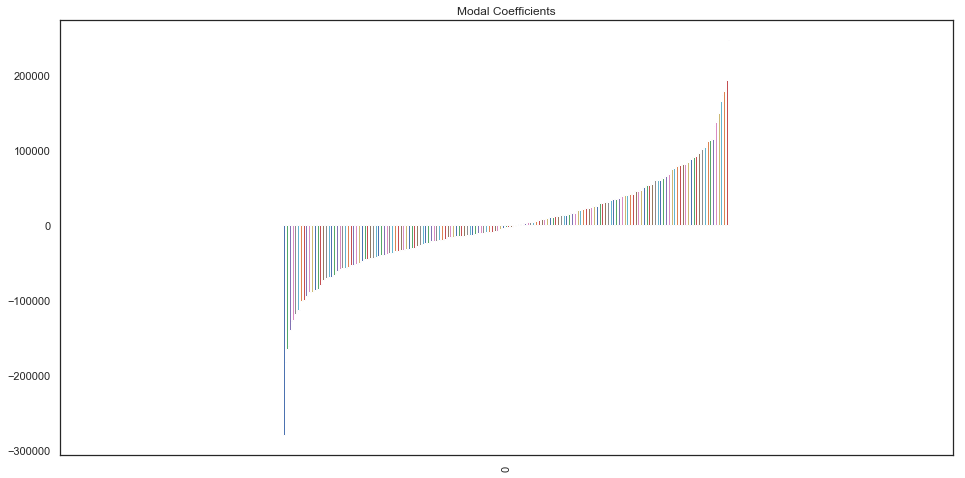

In [39]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [40]:
len(lasso_coef01.columns)

285

In [41]:
lasso_coef01

,yr_old^3,yr_old,sqft_living sqft_basement^2,bedrooms sqft_living sqft_basement,grade sqft_basement yr_old,bathrooms^2 waterfront,bedrooms floors grade,bedrooms,sqft_living^3,sqft_living floors grade,bedrooms^2 yr_old,sqft_living condition,sqft_lot^2,bedrooms bathrooms sqft_basement,condition sqft_basement yr_old,sqft_basement,sqft_living^2 waterfront,bedrooms bathrooms sqft_lot,bedrooms waterfront sqft_basement,bathrooms^2 sqft_basement,bathrooms sqft_living floors,bedrooms floors waterfront,sqft_living,sqft_living sqft_lot condition,floors^2 sqft_basement,sqft_living floors condition,bedrooms^2 floors,condition grade,sqft_lot floors waterfront,bedrooms waterfront^2,sqft_lot^3,bathrooms sqft_lot grade,bathrooms^3,bedrooms bathrooms condition,grade sqft_basement,bedrooms^2 condition,waterfront yr_old,grade yr_old,floors sqft_basement yr_old,sqft_lot floors,floors yr_old^2,sqft_basement^2 yr_old,sqft_living waterfront grade,sqft_lot grade yr_old,floors condition yr_old,floors condition^2,sqft_lot grade sqft_basement,bedrooms sqft_living yr_old,waterfront grade yr_old,waterfront grade sqft_basement,bathrooms^2 sqft_lot,sqft_living^2 yr_old,bedrooms yr_old^2,bedrooms sqft_living condition,bedrooms condition sqft_basement,floors^3,floors^2 yr_old,sqft_lot floors condition,sqft_living sqft_lot,sqft_living^2 floors,bedrooms^2 sqft_lot,bathrooms floors grade,sqft_lot floors^2,waterfront^3,bathrooms floors^2,sqft_living floors yr_old,condition^2 grade,bathrooms grade yr_old,floors sqft_basement^2,bedrooms waterfront grade,bathrooms grade sqft_basement,floors^2,bedrooms condition yr_old,sqft_lot grade,floors waterfront,grade,waterfront condition^2,bathrooms floors,sqft_lot waterfront yr_old,bathrooms waterfront yr_old,floors grade^2,sqft_lot yr_old,waterfront^2 grade,bedrooms sqft_living floors,bedrooms sqft_living sqft_lot,bedrooms grade,floors waterfront condition,sqft_living grade^2,sqft_lot floors sqft_basement,bathrooms sqft_living yr_old,sqft_living waterfront condition,sqft_lot condition sqft_basement,bathrooms floors condition,condition yr_old,waterfront sqft_basement^2,waterfront grade,bathrooms sqft_lot waterfront,bathrooms waterfront,bedrooms sqft_lot^2,sqft_lot^2 floors,bedrooms condition,sqft_lot^2 waterfront,waterfront condition sqft_basement,bathrooms sqft_basement,bedrooms grade yr_old,bathrooms^2 yr_old,grade^2 yr_old,bathrooms condition^2,condition^2 yr_old,condition^2,bedrooms floors,sqft_lot yr_old^2,floors,sqft_lot waterfront condition,bathrooms^2 sqft_living,sqft_living sqft_basement,condition sqft_basement^2,bedrooms sqft_lot grade,bedrooms floors sqft_basement,sqft_living^2 grade,bedrooms^3,bathrooms sqft_lot^2,bathrooms floors waterfront,sqft_lot condition^2,sqft_living condition^2,waterfront^2 yr_old,bathrooms,sqft_lot condition grade,waterfront^2,bedrooms waterfront yr_old,bathrooms condition,bedrooms sqft_living,sqft_lot floors grade,waterfront condition yr_old,grade sqft_basement^2,bathrooms floors yr_old,bathrooms waterfront sqft_basement,bathrooms sqft_lot yr_old,sqft_basement yr_old^2,bedrooms waterfront,sqft_living sqft_lot grade,floors waterfront sqft_basement,bedrooms^2 sqft_living,sqft_lot sqft_basement^2,sqft_lot sqft_basement yr_old,bathrooms condition yr_old,bathrooms sqft_living sqft_lot,bedrooms bathrooms^2,condition sqft_basement,waterfront^2 sqft_basement,bathrooms^2 condition,bathrooms grade^2,bathrooms waterfront condition,bathrooms sqft_living grade,bedrooms bathrooms,waterfront^2 condition,sqft_lot^2 condition,sqft_living condition yr_old,waterfront condition,sqft_lot waterfront,bedrooms grade^2,sqft_living waterfront yr_old,bathrooms sqft_lot sqft_basement,floors grade,bedrooms sqft_lot yr_old,bathrooms condition sqft_basement,floors^2 waterfront,bathrooms yr_old^2,sqft_lot condition yr_old,bathrooms sqft_lot condition,sqft_living sqft_lot yr_old,sqft_lot floors yr_old,sqft_living grade sqft_basement,bathrooms sqft_living,condition grade yr_old,bedrooms sqft_living waterfront,sqft_living 